In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy.random import seed
from sklearn.preprocessing import StandardScaler
from keras import optimizers, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.metrics import confusion_matrix, precision_recall_curve
import seaborn as sns
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [ ]:
seed(111)            # numpy # 7
SEED = 111           # train_test_split()
DATA_SPLIT_PCT = 0.3 # train_test_split()
epochs = 100         
batch = 16
lr = 3e-4            # Karpathy Constant

In [ ]:
raw_data = pd.read_csv("https://drive.google.com/uc?export=download&id=1TjBvV9-L8BP565uEQvI32Z4Tzc8lp41m")

# 0.run

In [ ]:
df = raw_data.copy()

In [ ]:
df.drop(columns={"Unnamed: 0"}, inplace = True) # drop date column
df.drop(columns={"52_XHCC90"},  inplace = True) # drop target column 
df.rename(columns={"Anomaly": "y"}, inplace = True) # name anomaly as y
df.tail(n = 1)

,52TI766,52PI250,52FC231,52TI737,52FC1127,52TI878,52TI735,52FR235,52FC133,52FC1143,y
58717,390.953125,21.305176,9.96875,123.023733,5.356079,80.148438,381.683853,371.074497,7590.25,1293.875,0


In [ ]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''
    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [ ]:
# Shift the response column y by 3 rows 
timesteps = 3
df = curve_shift(df, shift_by = timesteps)

In [ ]:
df["y"].value_counts()

0.0    53525
1.0     5193
Name: y, dtype: int64

In [ ]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

In [ ]:
def temporalize(X, y, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: 
              (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with 
              X, i.e. y[i] should correspond to X[i]. 
              Shape: n_observations.
    lookback  The window size to look back in the past 
              records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: 
              ((n_observations-lookback-1) x lookback x 
              n_features)
    output_y  A 1D array of shape: 
              (n_observations-lookback-1), aligned with X.
    '''
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

In [ ]:
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = timesteps)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [ ]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [ ]:
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], timesteps, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], timesteps, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], timesteps, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], timesteps, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

In [ ]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [ ]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [ ]:
X_train_y0_scaled = scale(X_train_y0, scaler)

In [ ]:
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0. -0.  0.  0.  0.  0.  0. -0.  0. -0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

In [ ]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 

In [ ]:
lstm_autoencoder = Sequential()
# Encode
lstm_autoencoder.add(LSTM(16, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(8, activation='relu', return_sequences=False))

# Decode
lstm_autoencoder.add(RepeatVector(timesteps))
lstm_autoencoder.add(LSTM(8, activation='relu', return_sequences=True))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 16)             1728      
                                                                 
 dropout (Dropout)           (None, 3, 16)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 repeat_vector (RepeatVector  (None, 3, 8)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 3, 8)              544       
                                                                 
 dropout_1 (Dropout)         (None, 3, 8)              0         
                                                        

In [ ]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=1, 
                                                callbacks = EarlyStopping(monitor='loss', patience=5)).history

Epoch 1/100
1676/1676 [==============================] - 19s 8ms/step - loss: 0.6385 - val_loss: 0.3713
Epoch 2/100
1676/1676 [==============================] - 18s 11ms/step - loss: 0.3522 - val_loss: 0.2580
Epoch 3/100
1676/1676 [==============================] - 12s 7ms/step - loss: 0.2709 - val_loss: 0.1844
Epoch 4/100
1676/1676 [==============================] - 12s 7ms/step - loss: 0.2247 - val_loss: 0.1545
Epoch 5/100
1676/1676 [==============================] - 12s 7ms/step - loss: 0.2044 - val_loss: 0.1404
Epoch 6/100
1676/1676 [==============================] - 12s 7ms/step - loss: 0.1903 - val_loss: 0.1245
Epoch 7/100
1676/1676 [==============================] - 12s 7ms/step - loss: 0.1804 - val_loss: 0.1164
Epoch 8/100
1676/1676 [==============================] - 12s 7ms/step - loss: 0.1722 - val_loss: 0.1097
Epoch 9/100
1676/1676 [==============================] - 13s 8ms/step - loss: 0.1665 - val_loss: 0.1054
Epoch 10/100
1676/1676 [==============================] - 12s 7

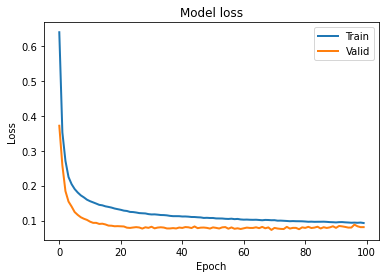

In [ ]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

386/386 [==============================] - 1s 2ms/step


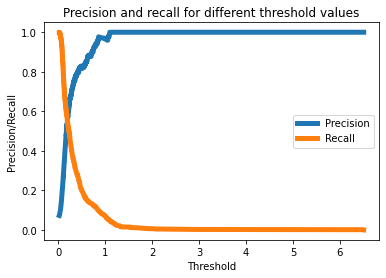

In [ ]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df_valid = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df_valid.True_class, error_df_valid.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

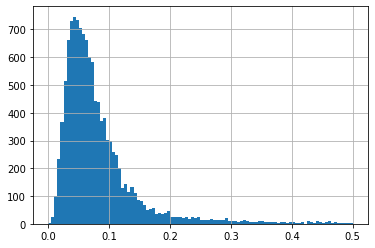

In [ ]:
error_df_valid.loc[:, "Reconstruction_error"].hist(bins=100, range=[0, 0.5])

In [ ]:
# predict normal data, get costruction error for normal data, choose a quantile as threshold
threshold = error_df_valid.loc[:, "Reconstruction_error"].quantile(0.8)
print(f"thrshold: {threshold}")

thrshold: 0.1106268605367072


551/551 [==============================] - 1s 2ms/step


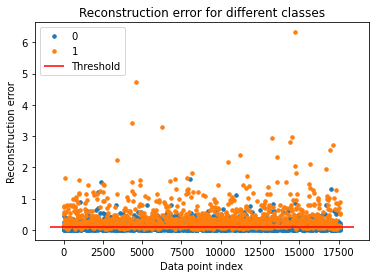

In [ ]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

# threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "1" if name == 1 else "0")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

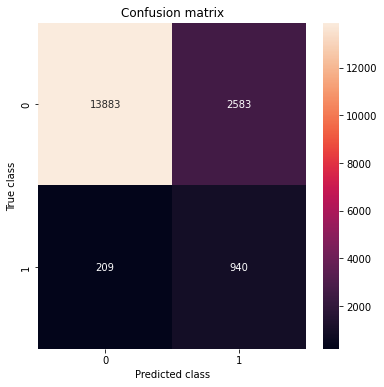

In [ ]:
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
print(f"true 0 rate: {(conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])).round(3)}\ntrue 1 rate: {(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])).round(3)}")

true 0 rate: 0.843
true 1 rate: 0.818


# 1.temp